# House Prices

Import Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid', context='notebook', palette='deep')

import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina'

Import Datasets

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

Check Datasets size

In [3]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Explore Data

In [5]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We can see that the mean value is around 180 000 USD and we can say with standard deviation : 100 000 USD < 68% of the data < 260 000 USD

Visualization

Skew is: 1.8828757597682129
Kurt is: 6.536281860064529


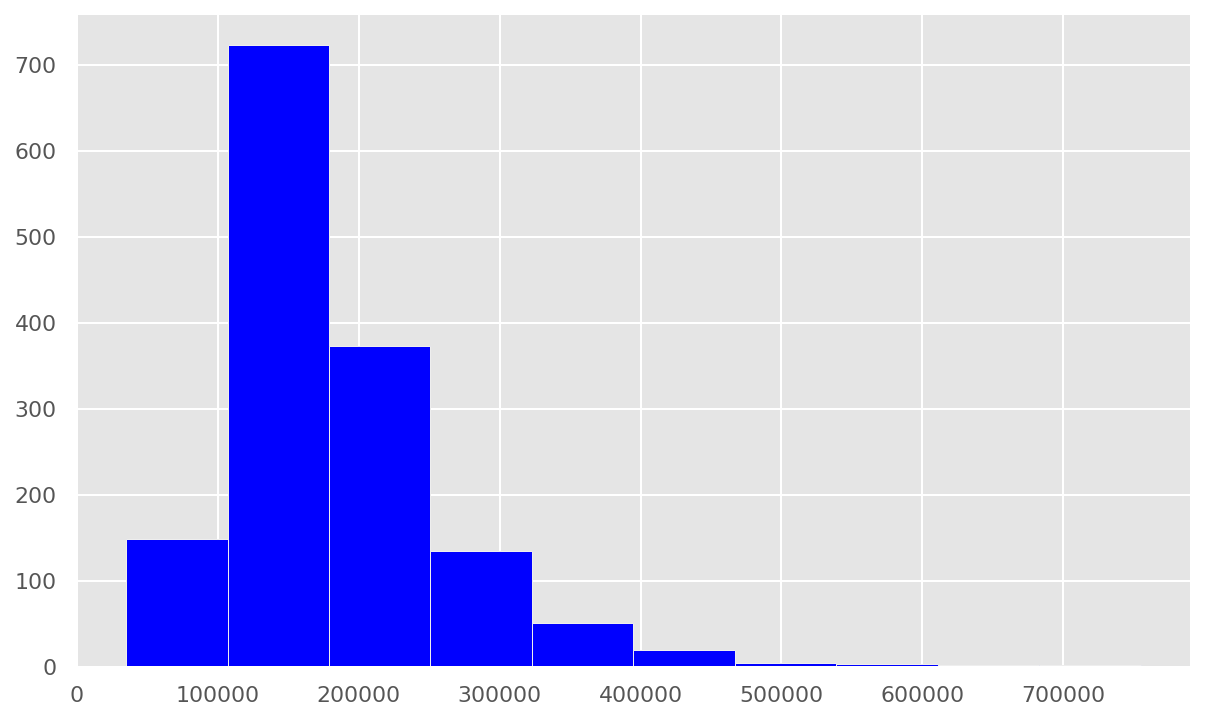

In [6]:
print ("Skew is:", train.SalePrice.skew())
print ("Kurt is:", train.SalePrice.kurt())
plt.hist(train.SalePrice, color='blue')
plt.show()

The skewness and the kurtosis show that the sale prices deviate from the normal distribution and that there is a peak.  
We want a distribution as normal as possible so we will try to fix this.

We use log method from numpy to transform train.SalePrice

Skew is: 0.12133506220520406
Kurt is: 0.8095319958036296


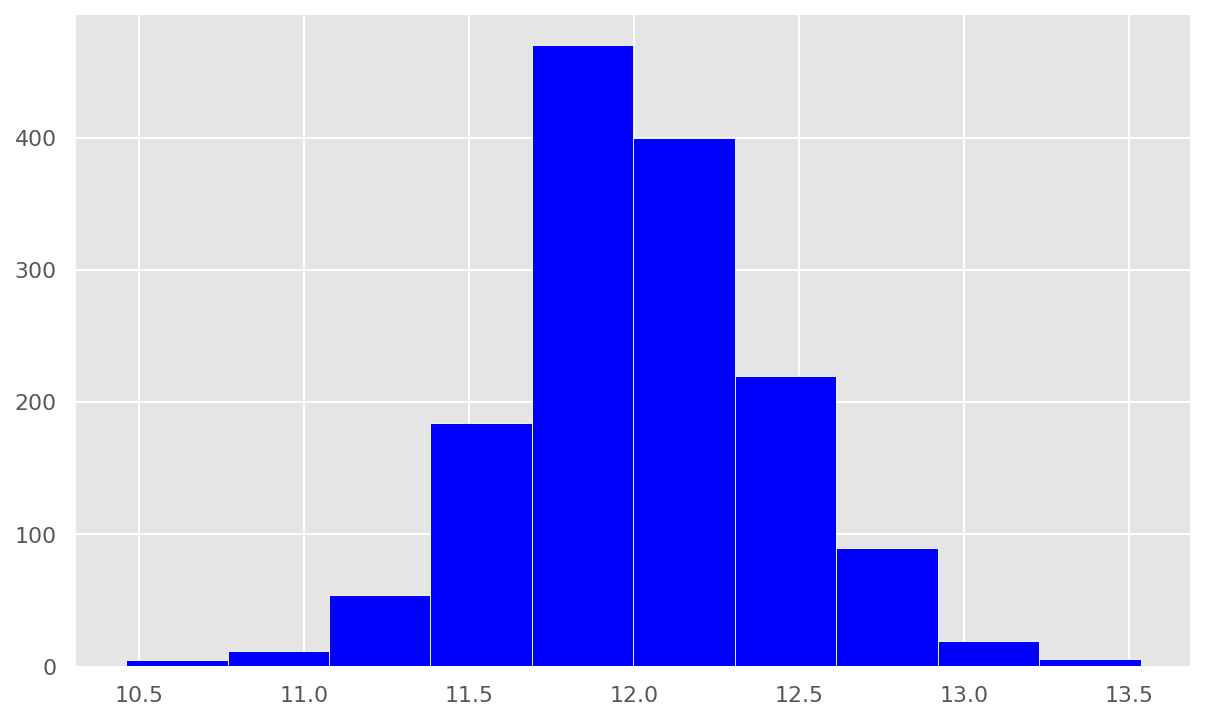

In [7]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
print ("Kurt is:", target.kurt())
plt.hist(target, color='blue')
plt.show()

## Mutivariable analysis

In [8]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

### Correlation

In [9]:
corr = numeric_features.corr()

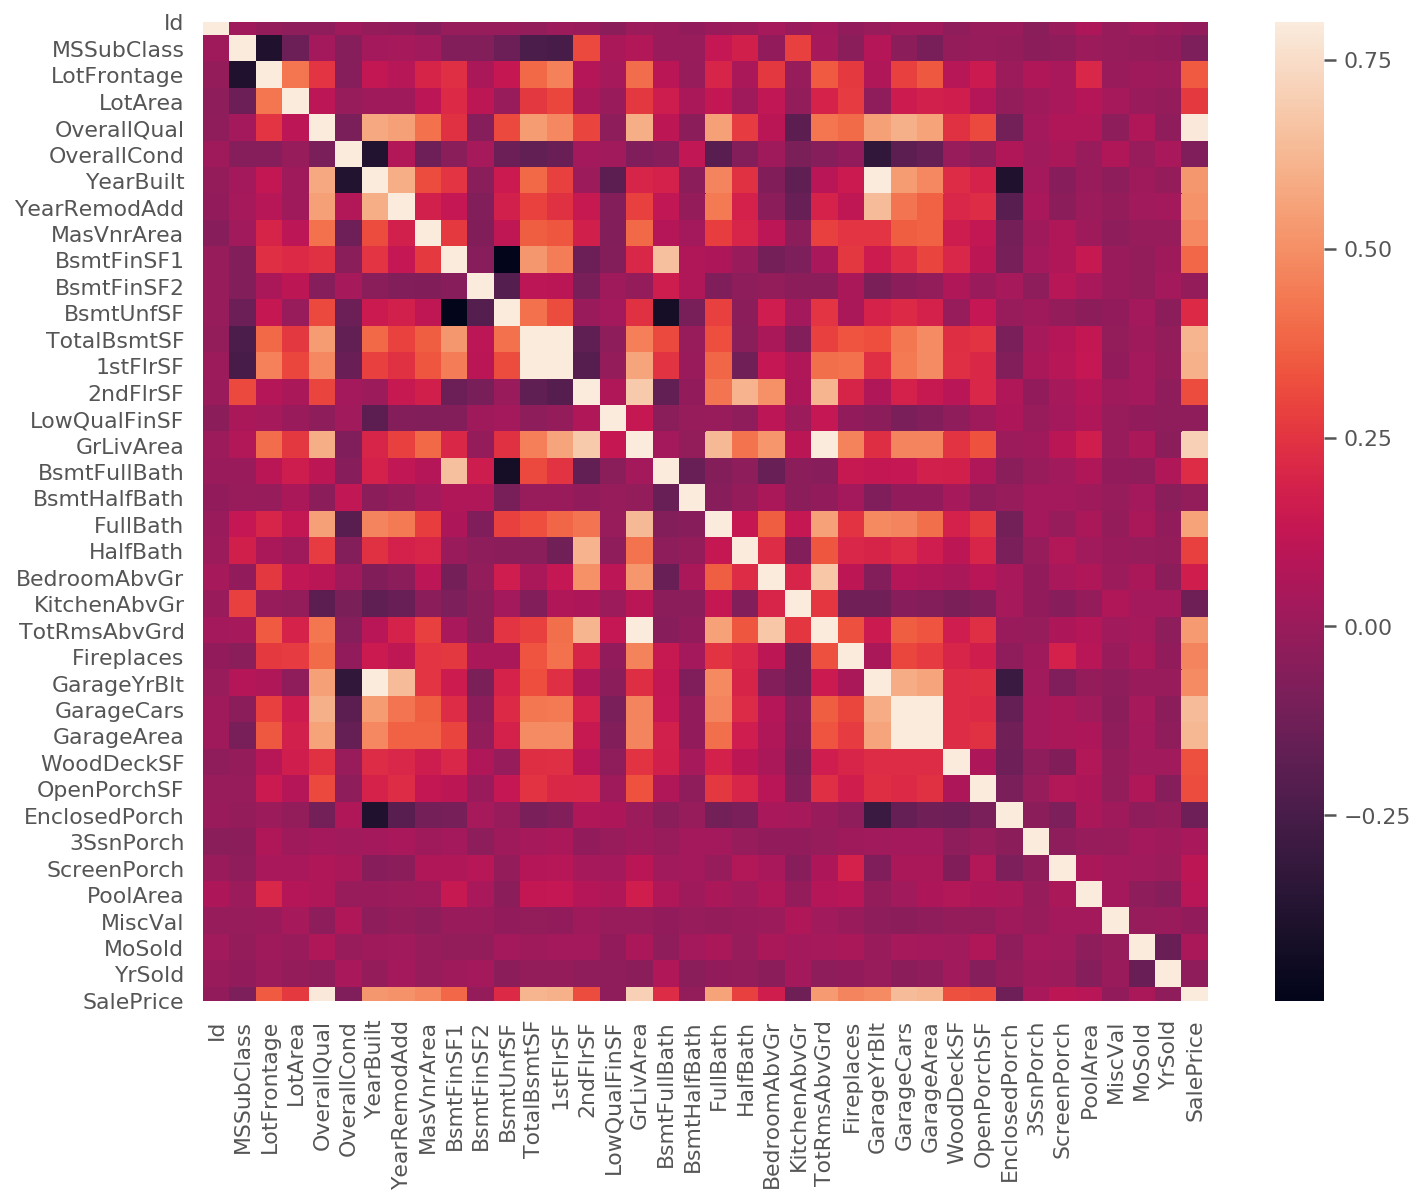

In [10]:
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corr, vmax = .8, square = True)

In [11]:
print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


The first five features are the most positively correlated with SalePrice, while the next five are the most negatively correlated.

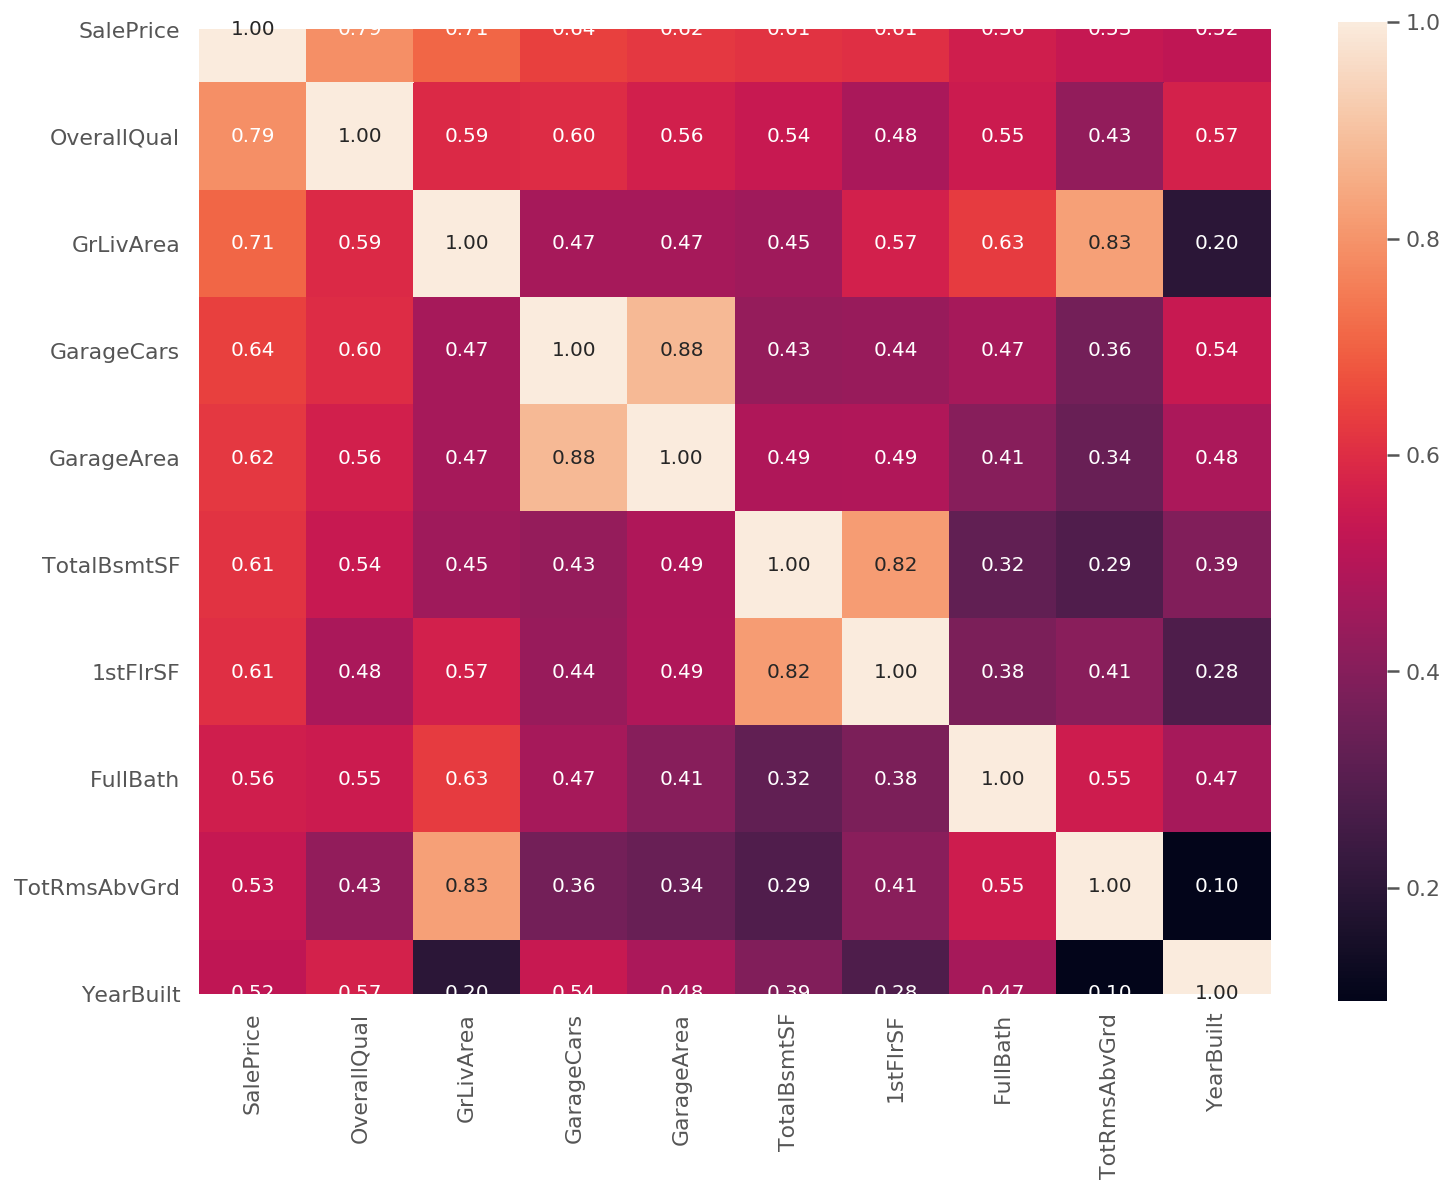

In [12]:
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
most_corr = train[cols].corr()

f, ax = plt.subplots(figsize = (12, 9))
most_corr_heatmap = sns.heatmap(most_corr, 
                             annot = True, 
                             square = True, 
                             fmt = '.2f', 
                             annot_kws = {'size': 10},
                             yticklabels = cols.values,
                             xticklabels = cols.values
                            )

#### OverallQual

In [13]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [14]:
quality_pivot = train.pivot_table(index='OverallQual',
                  values='SalePrice', aggfunc=np.median)

In [15]:
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


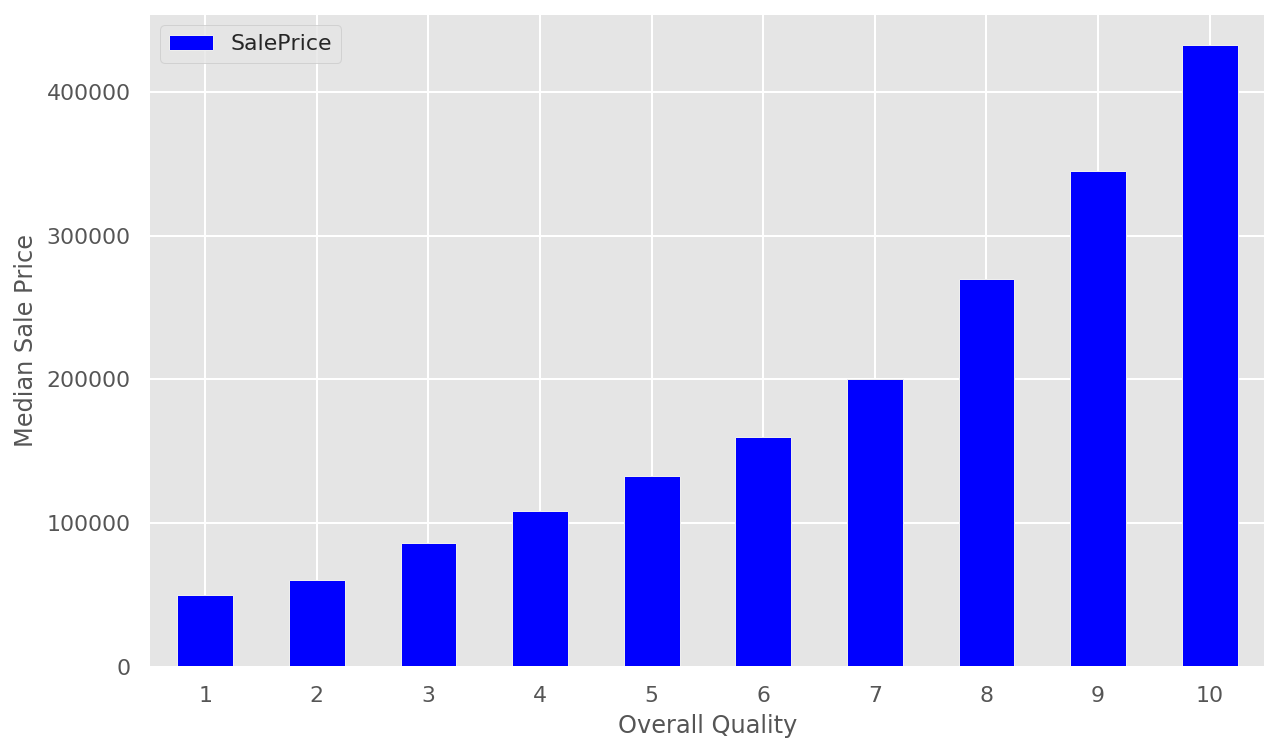

In [16]:
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

#### GrLivArea

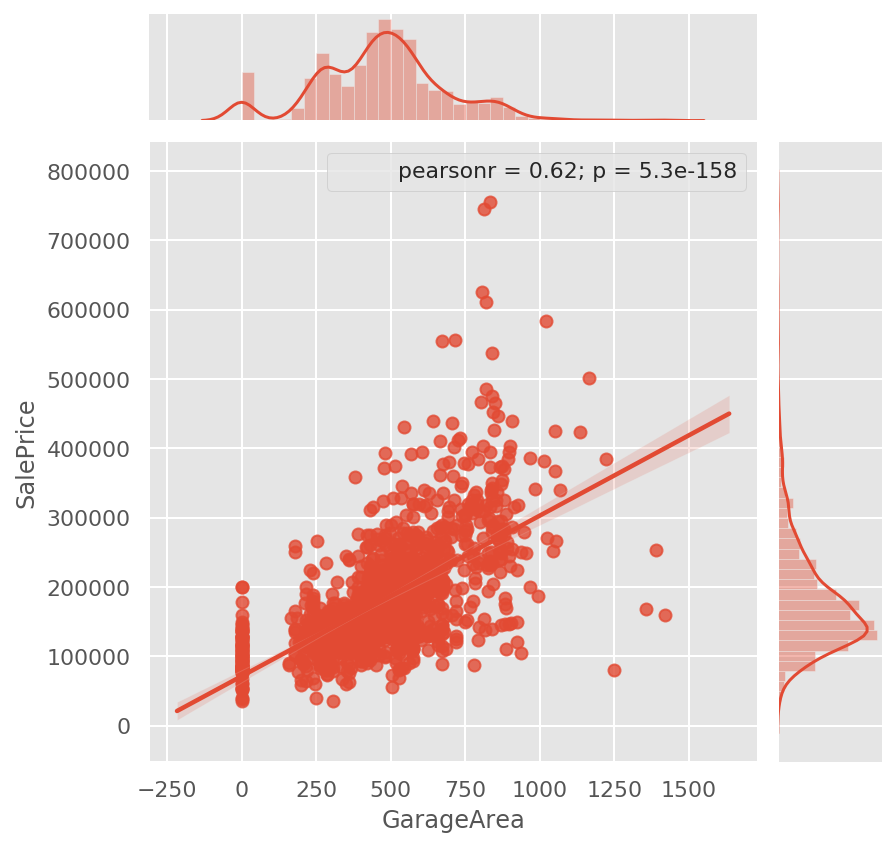

In [17]:
sns.jointplot(x=train['GarageArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

In [18]:
# Remove outliers (two points where GrLivArea > 4000 and SalePrice < 200 000)
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 200000)].index).reset_index(drop=True)

#### GarageCars

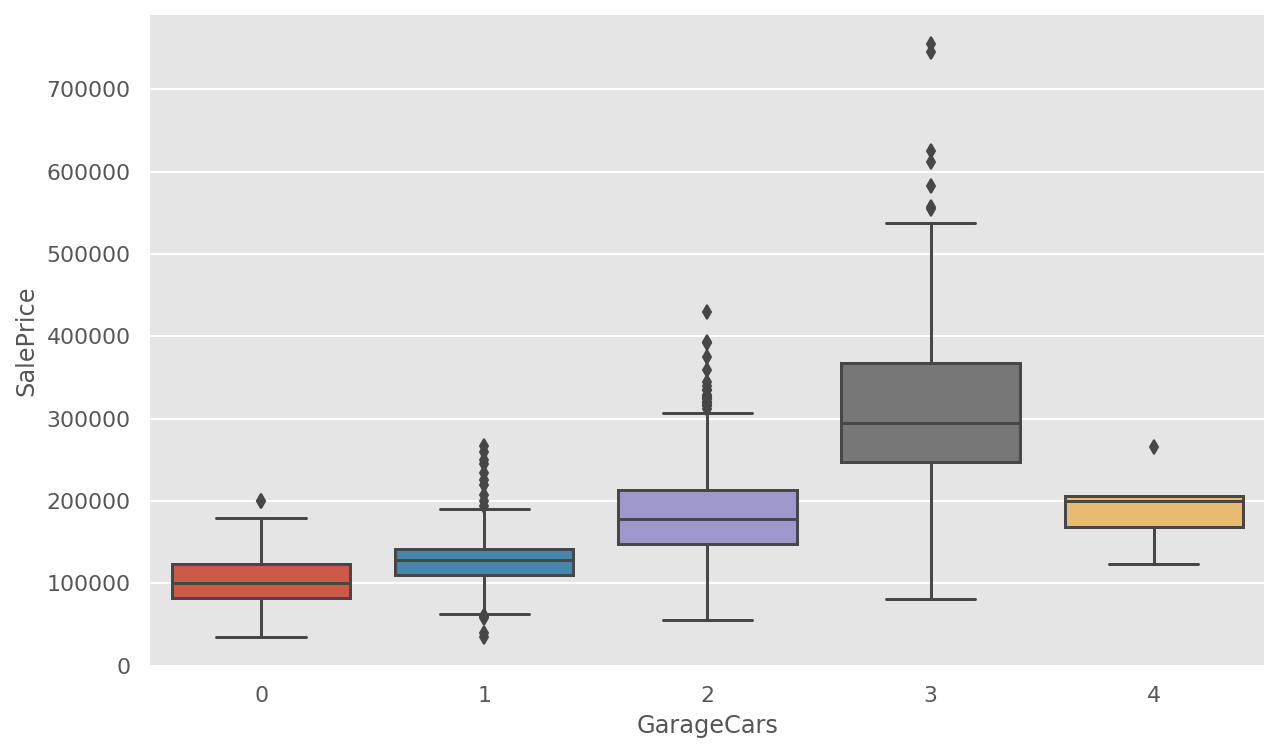

In [19]:
sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])

In [20]:
# Remove outliers (where GarageCars > 3 and SalePrice < 300 000)
train = train.drop(train[(train['GarageCars'] > 3) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

#### GarageArea

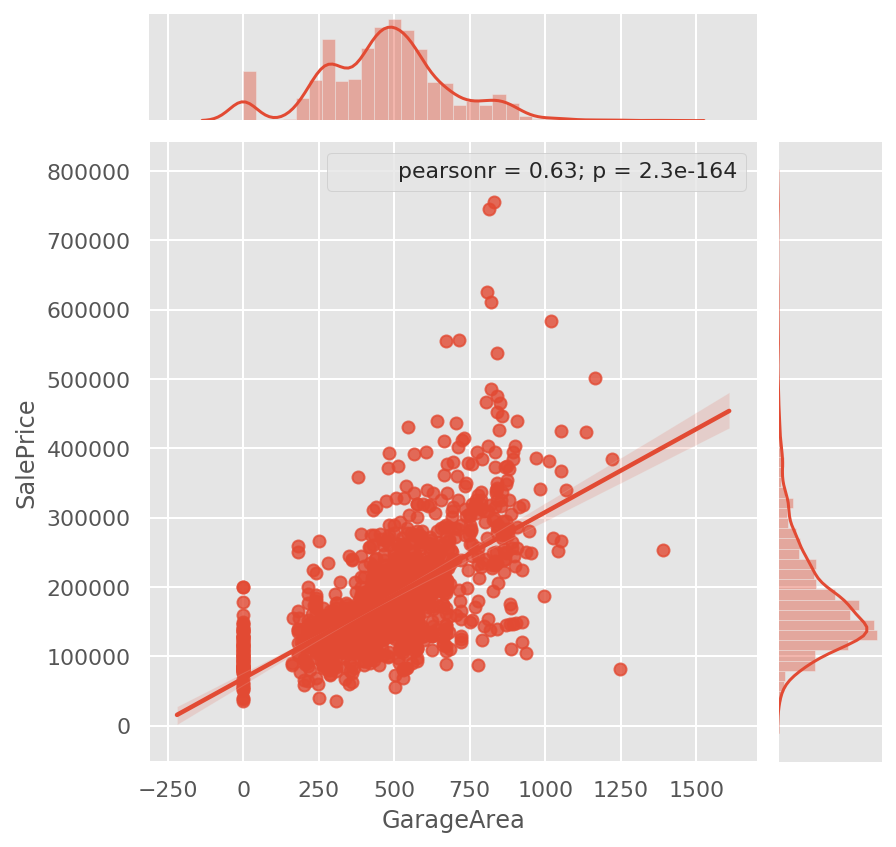

In [21]:
sns.jointplot(x=train['GarageArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

In [22]:
train = train.drop(train[(train['GarageArea'] > 1200) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

#### TotalBsmtSF

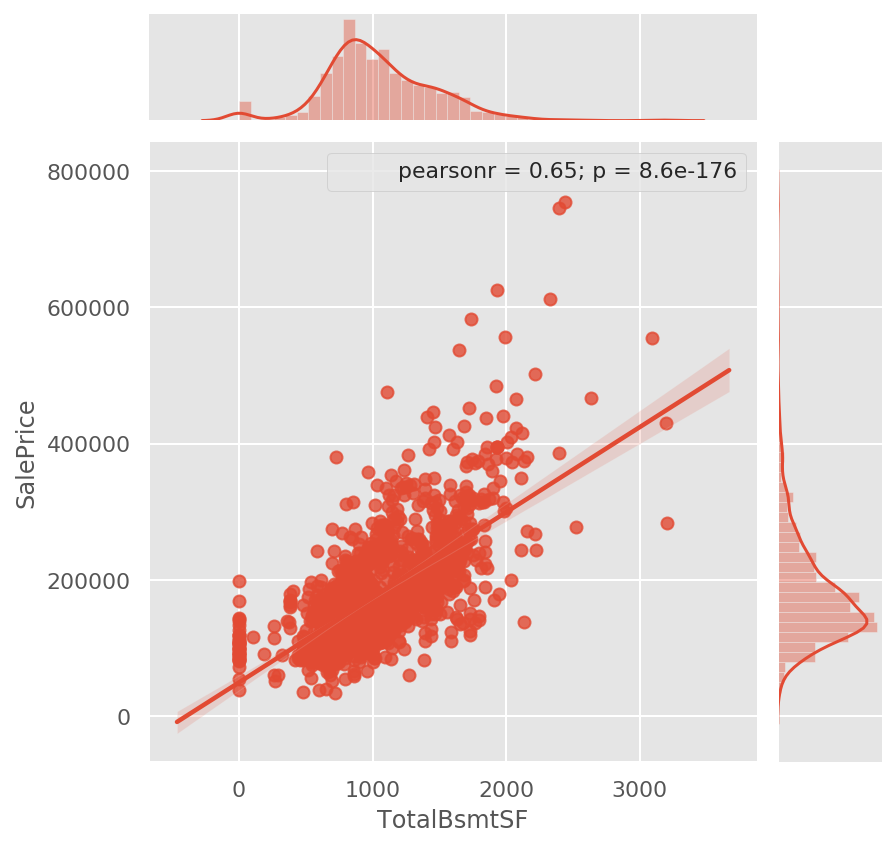

In [23]:
sns.jointplot(x=train['TotalBsmtSF'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

#### 1stFlrSF

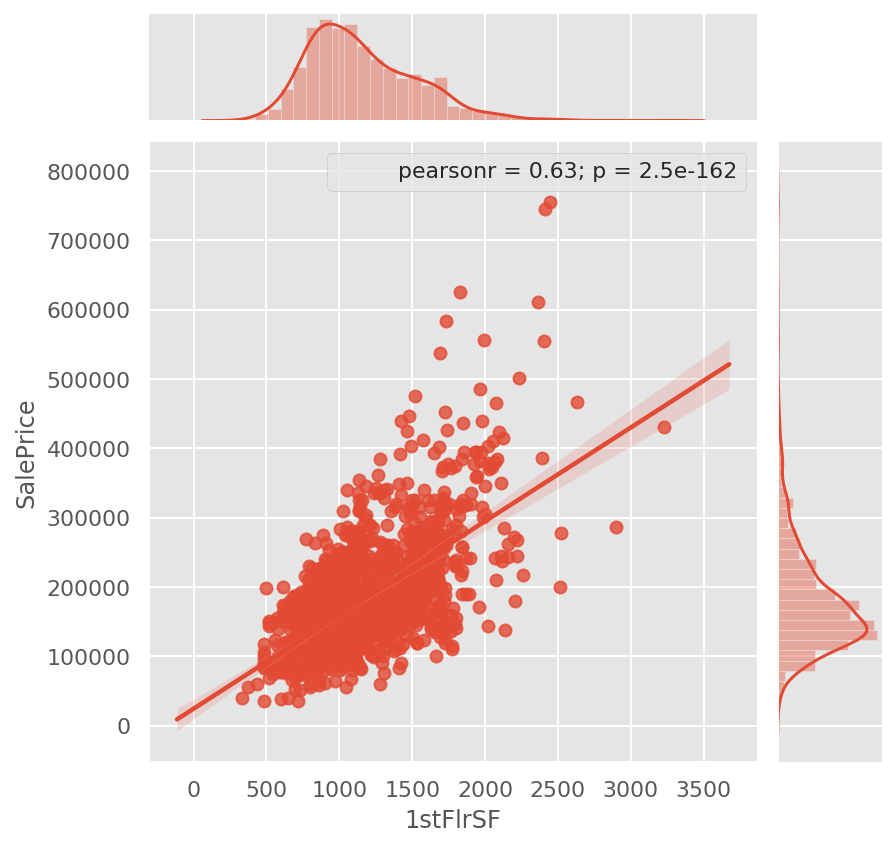

In [24]:
sns.jointplot(x=train['1stFlrSF'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

#### TotRmsAbvGrd

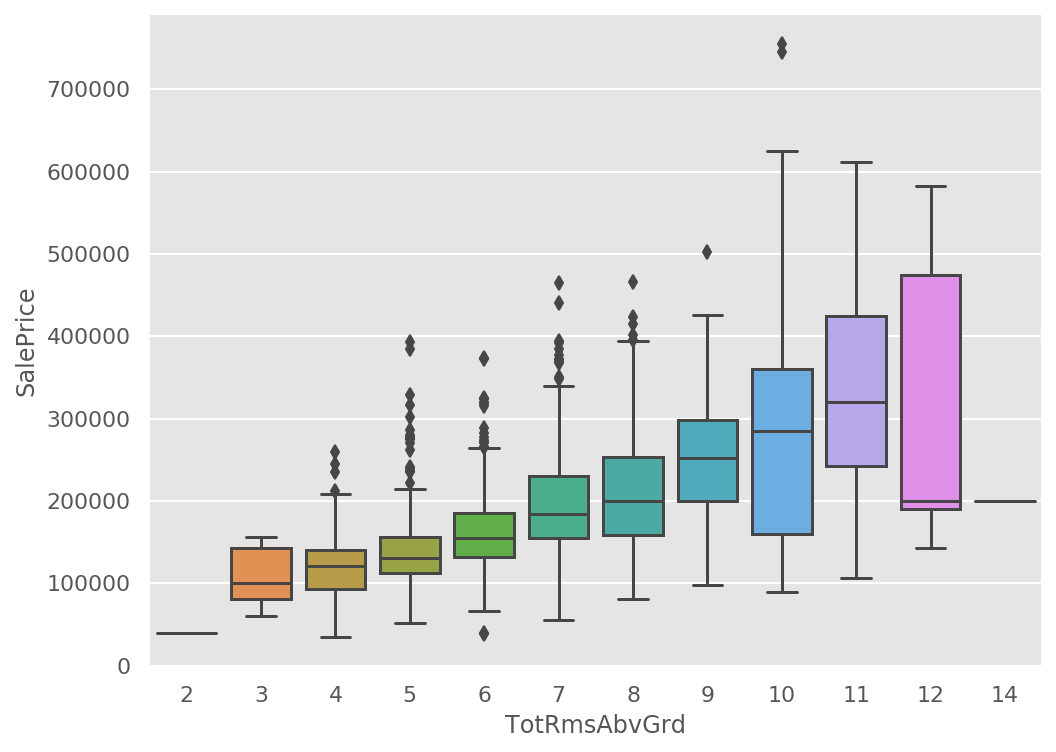

In [25]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])

#### YearBuilt

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

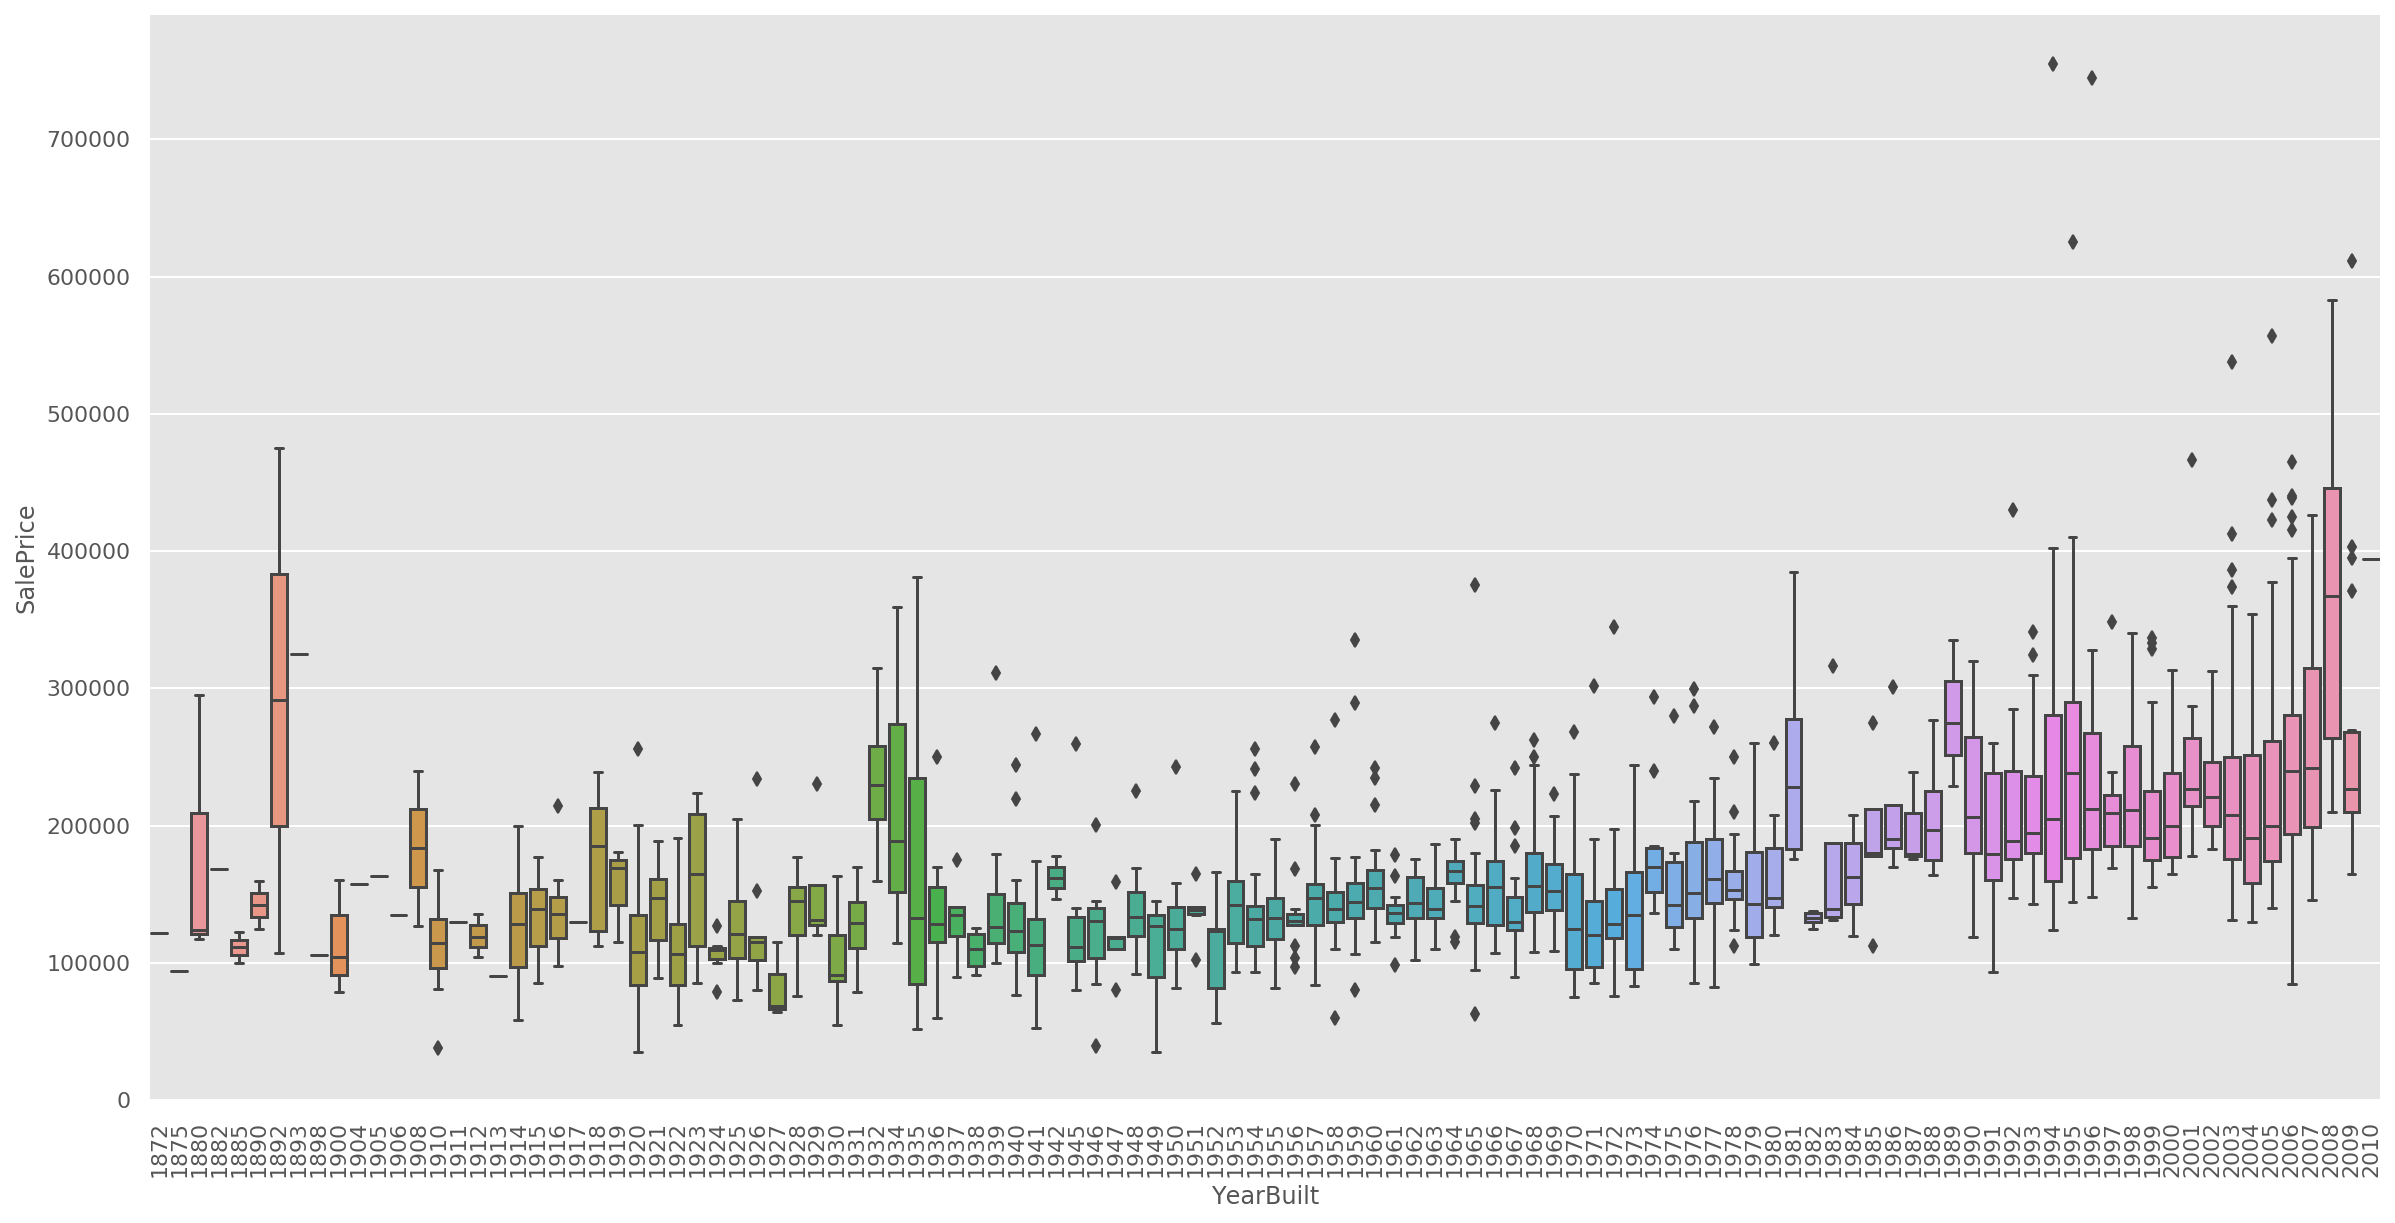

In [26]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x = train['YearBuilt'], y = train['SalePrice'])
plt.xticks(rotation = 90)

### Handling Missing Values

In [27]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1445
MiscFeature,1398
Alley,1361
Fence,1171
FireplaceQu,686
LotFrontage,258
GarageCond,81
GarageType,81
GarageYrBlt,81


With the help of the description file, we can say :

* **PoolQC** : data description says NA means "No Pool"
* **MiscFeature** : data description says NA means "no misc feature"
* **Alley** : data description says NA means "no alley access"
* **Fence** : data description says NA means "no fence"
* **FireplaceQu** : data description says NA means "no fireplace"
* **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
* **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with "None".
* **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0.
* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath**: Replacing missing data with 0.
* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there isn't a basement.
* **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
* **MSZoning** (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'.
* **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
* **Functional** : data description says NA means typical.
* **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
* **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
* **Exterior1st and Exterior2nd **: Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
* **SaleType** : Fill in again with most frequent which is "WD"
* **MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [28]:
datasets = [train, test]

for dataset in datasets:
    
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'PoolQC', 'MiscFeature', 'MiscFeature', 'Fence',
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'MasVnrType', 'MSSubClass', 'Alley'):
        dataset[col] = dataset[col].fillna('None')
    
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                'MasVnrArea'):
        dataset[col] = dataset[col].fillna(0)
        
    dataset.drop(['Utilities'], axis=1, inplace=True)
    
    dataset["Functional"] = dataset["Functional"].fillna("Typ")

### Categorical features

In [29]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1451,1451,1451,1451,1451,1451,1451,1451,1451,1451,...,1451,1451,1451,1451,1451,1451,1451,1451,1451,1451
unique,5,2,3,4,4,5,3,25,9,8,...,7,4,6,6,3,4,5,5,9,6
top,RL,Pave,None,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,...,Attchd,Unf,TA,TA,Y,None,None,None,WD,Normal
freq,1145,1446,1361,919,1306,1045,1374,223,1254,1437,...,867,602,1302,1317,1332,1445,1171,1398,1262,1193


### Features Engineering and Transformation

We create a new column called enc_street

In [30]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [31]:
print ('Encoded: \n')
print (train.enc_street.value_counts())

Encoded: 

1    1446
0       5
Name: enc_street, dtype: int64


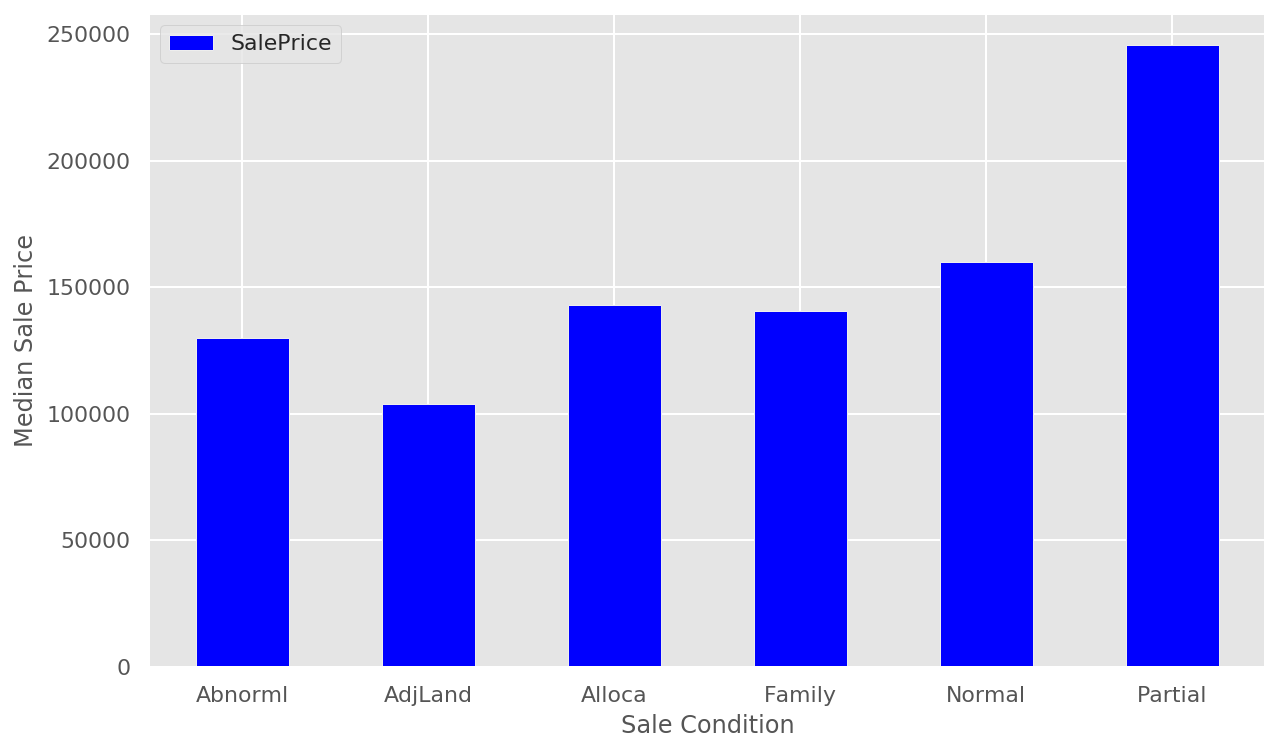

In [32]:
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [33]:
def encode(x):
    return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

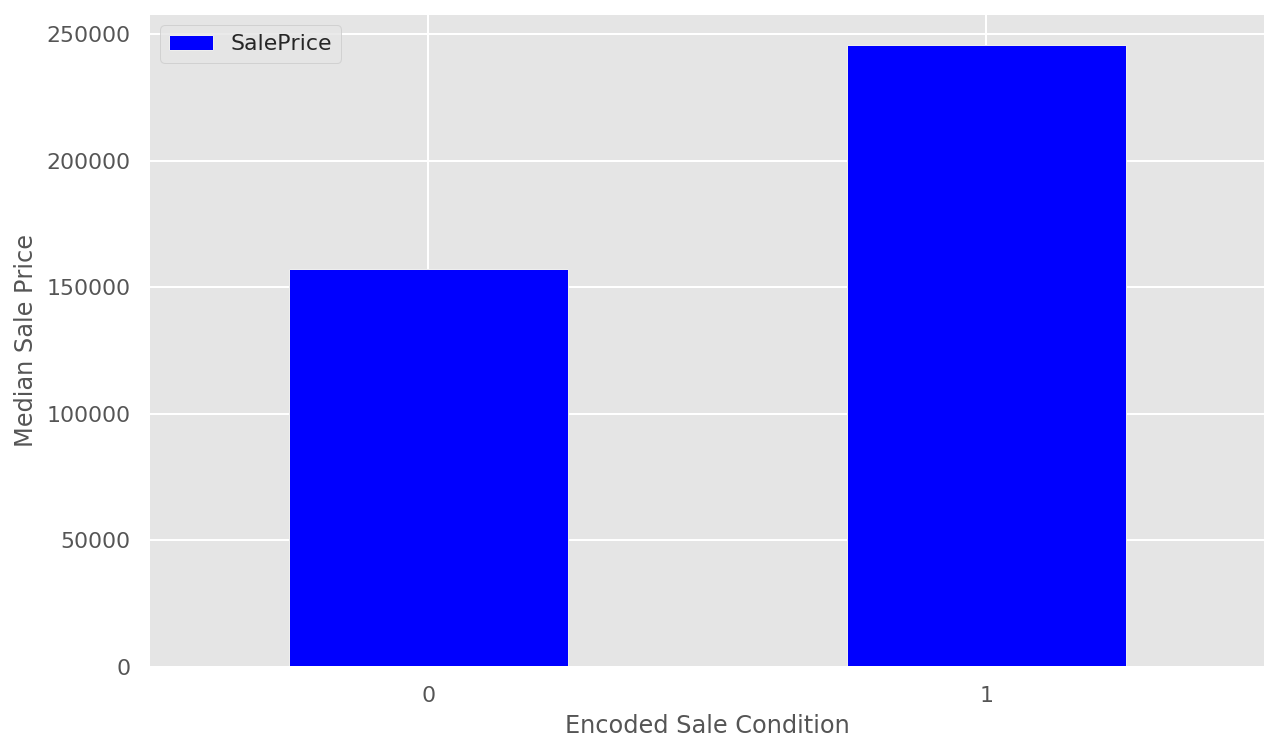

In [34]:
condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [35]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [36]:
data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,enc_street,enc_condition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,0,2,2008,208500,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,5,2007,181500,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,0,9,2008,223500,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,272,0,0,0,0,2,2006,140000,1,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,0,12,2008,250000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,0,0,0,0,8,2007,175000,1,0
1447,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,0,0,0,0,0,2,2010,210000,1,0
1448,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,0,0,0,2500,5,2010,266500,1,0
1449,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,112,0,0,0,0,4,2010,142125,1,0


In [37]:
sum(data.isnull().sum() != 0)

0

## Modeling

In [38]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

### Train-test split

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
                          X, y, random_state=42, test_size=.33)

### Linear Regression

In [40]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

#### Train model with the fit method

In [41]:
model = lr.fit(X_train, y_train)

#### Evaluate model with metrics

In [42]:
print ("R^2 is: \n", model.score(X_val, y_val))

R^2 is: 
 0.8759970613759057


In [43]:
predictions = model.predict(X_val)

In [44]:
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_val, predictions))

RMSE is: 
 0.01827448371643176


#### Visualization

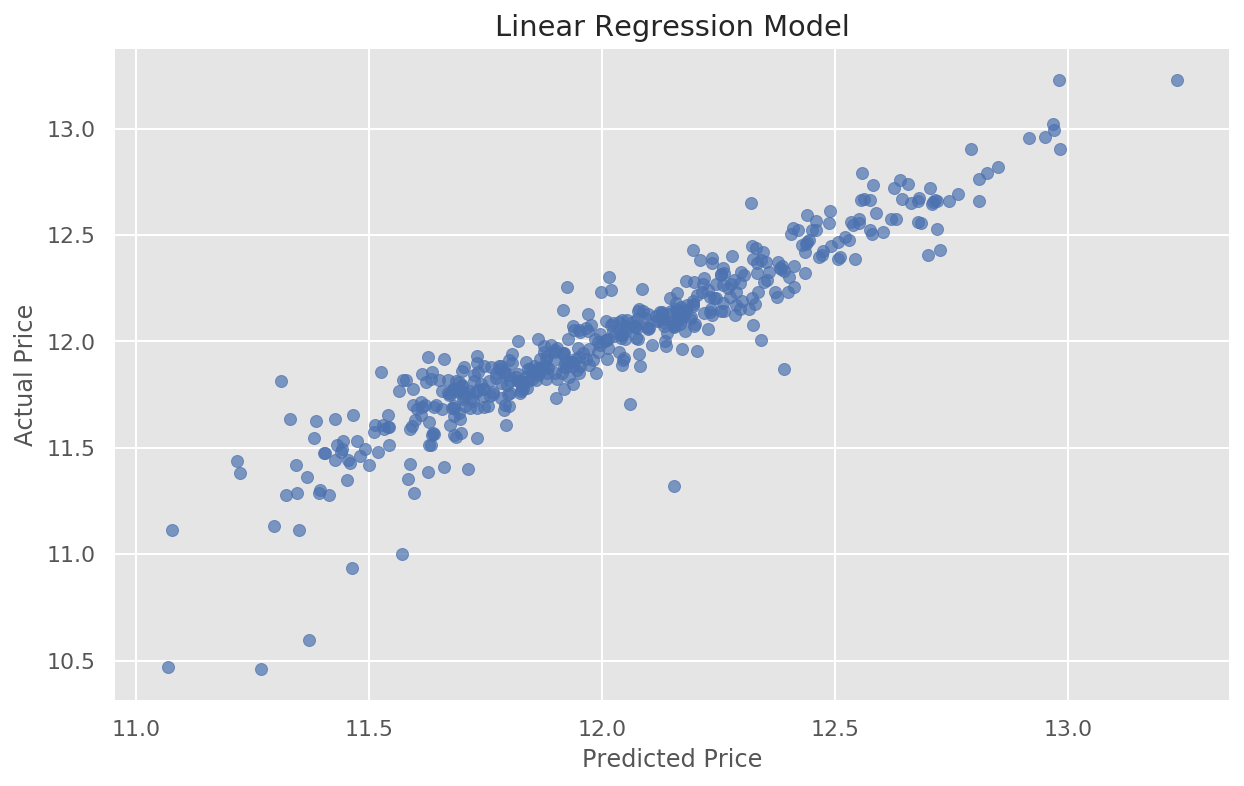

In [45]:
actual_values = y_val
plt.scatter(predictions, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

### XGBoost Model

In [46]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(min_child_weight= 7, 
                        max_depth= 10, 
                        learning_rate= 0.15, 
                        gamma= 0.1, 
                        colsample_bytree= 0.5,
                        random_state=42)

#### Train model with the fit method

In [47]:
xgbr.fit(X_train, y_train)

[10:27:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

#### Evaluate model with metrics

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predictions_xgbr = xgbr.predict(X_val)
mse_xgbr = mean_squared_error(y_val, predictions_xgbr)

print("MSE XGBR: %.4f" % mse_xgbr)
print("RMSE XGBR: %.4f" % np.sqrt(mse_xgbr))

MSE XGBR: 0.0194
RMSE XGBR: 0.1393


#### Visualization

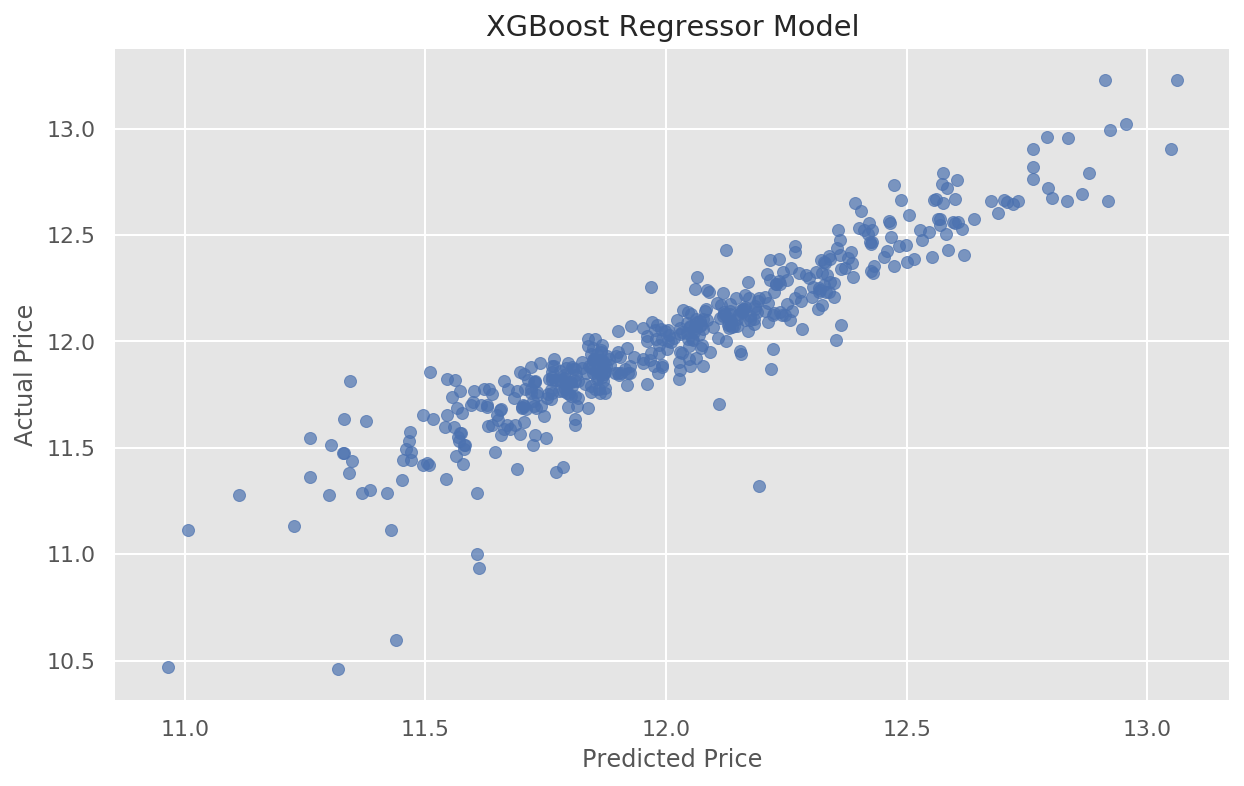

In [49]:
actual_values = y_val
plt.scatter(predictions_xgbr, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Regressor Model')
plt.show()

### Ridge Regularization

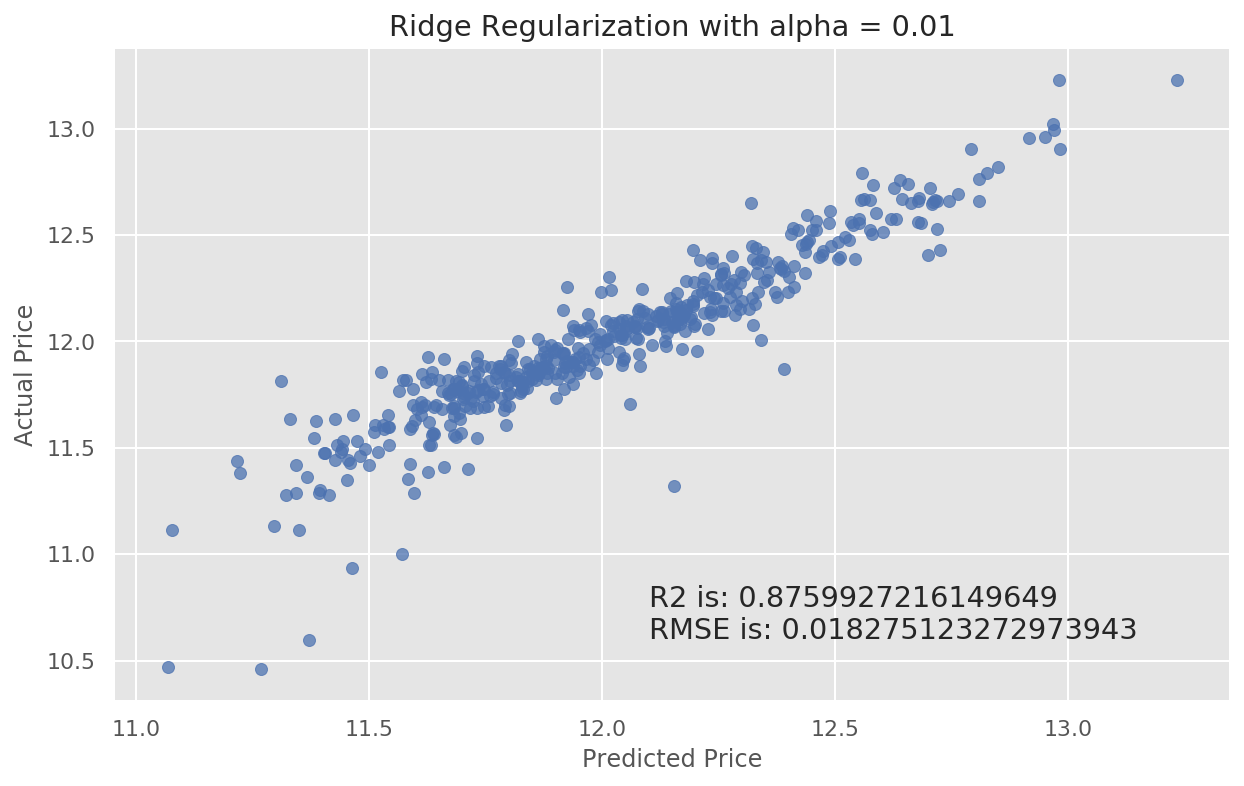

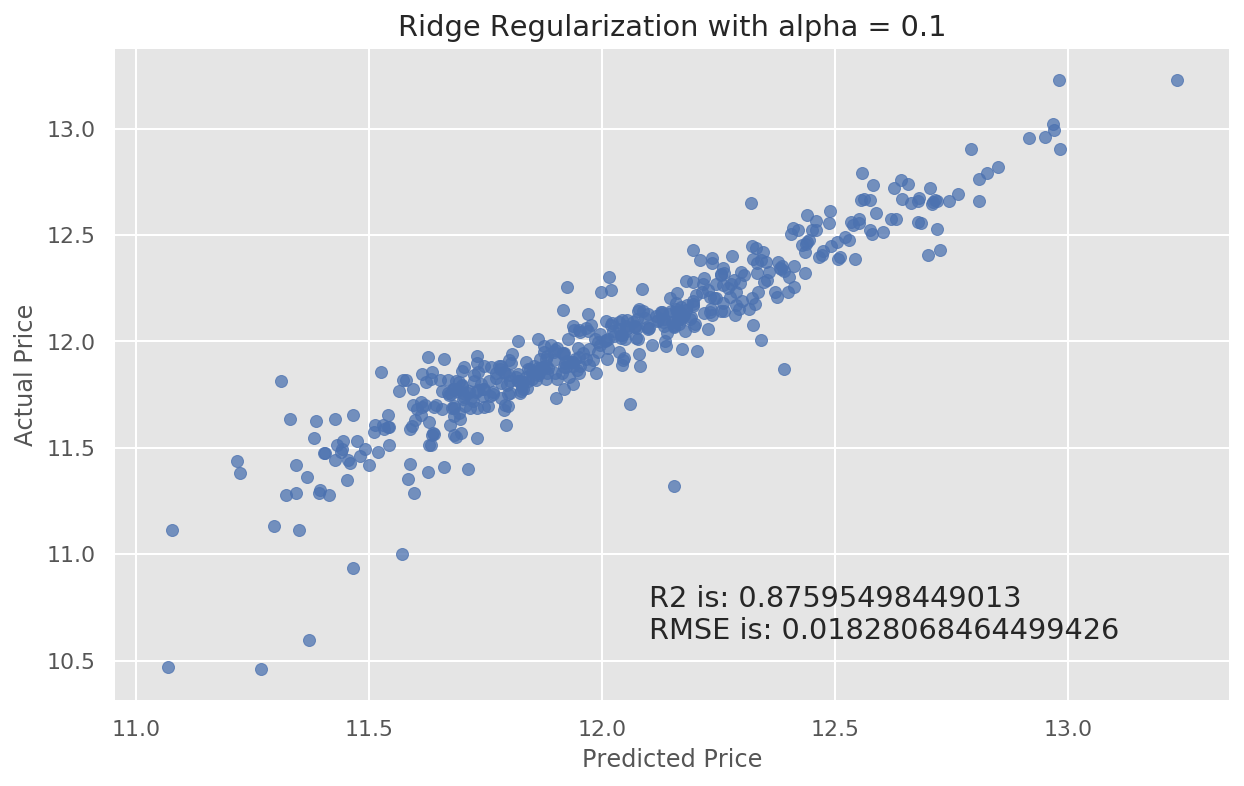

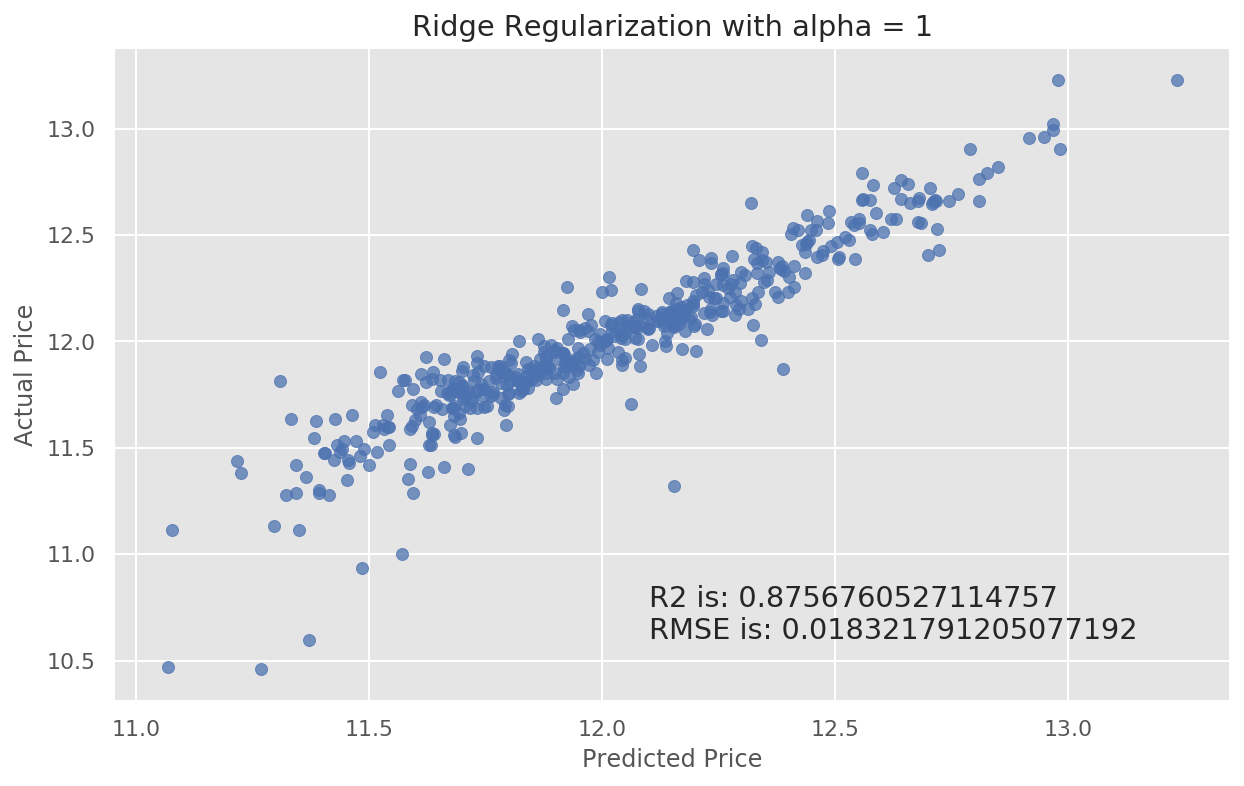

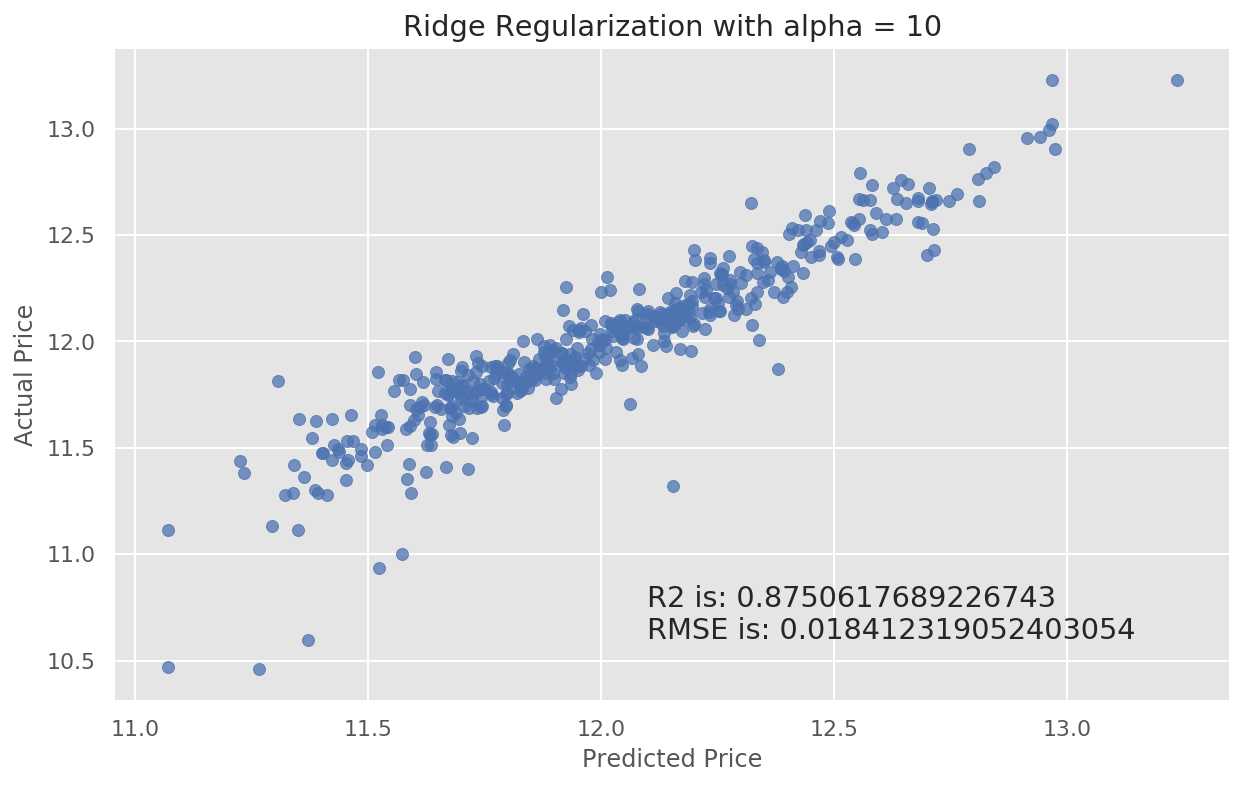

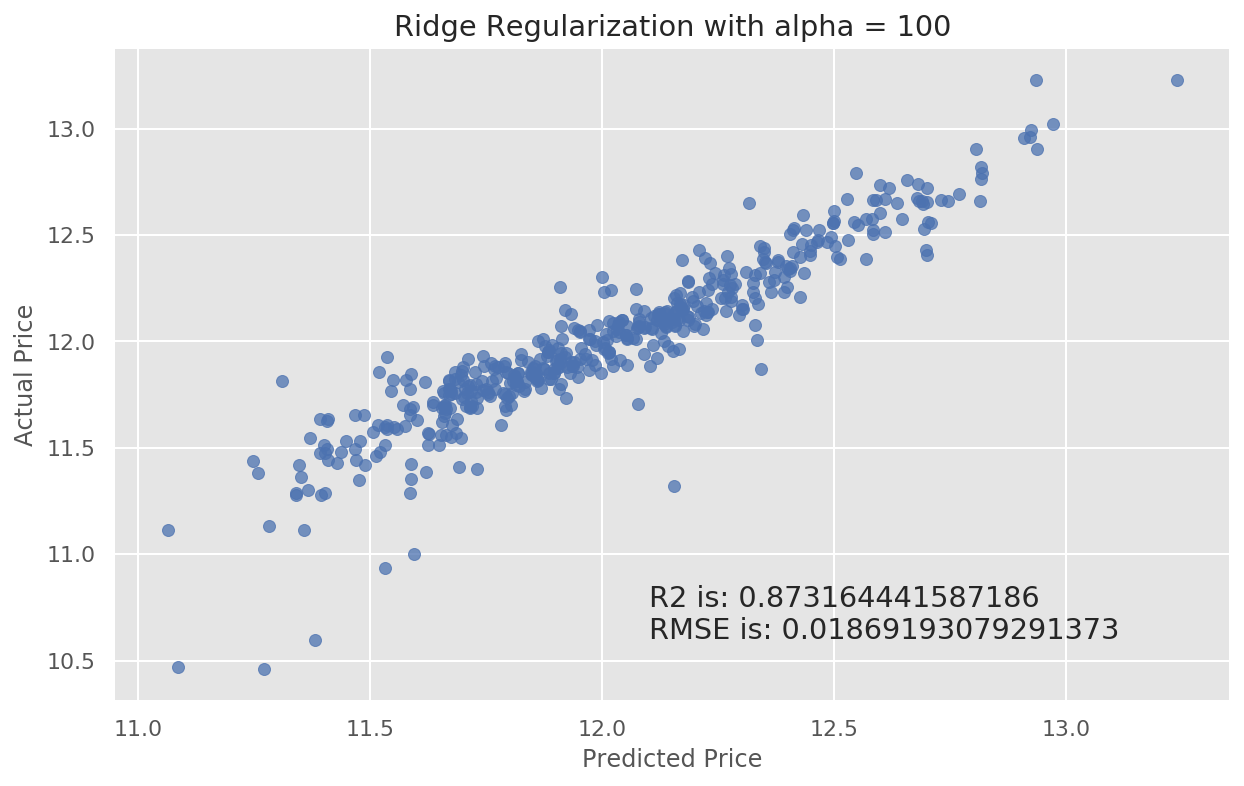

In [50]:
for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_val)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(X_val, y_val),
                    mean_squared_error(y_val, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

### Submission

#### Create submission dataFrame

In [51]:
submission = pd.DataFrame()
submission['Id'] = test.Id

X_test = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()

#### Test model on the test set

In [52]:
predictions = xgbr.predict(X_test)

Transform the predictions to the correct form because we have log values for SalePrice

In [53]:
final_predictions = np.exp(predictions)

In [54]:
print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

Original predictions are: 
 [11.814451 12.019621 12.092316 12.122129 12.211462] 

Final predictions are: 
 [135191.98 165979.73 178494.95 183896.69 201080.8 ]


In [55]:
submission['SalePrice'] = final_predictions
submission.head()

,Id,SalePrice
0,1461,135191.984375
1,1462,165979.734375
2,1463,178494.953125
3,1464,183896.687500
4,1465,201080.796875


In [56]:
submission.to_csv('submission1.csv', index=False)